In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
import datetime as dt


In [3]:
import os
print(os.getcwd())
pd.set_option('mode.chained_assignment', None)


C:\Users\Lena\Dokumente\GitHub\DataLiteracy


In [68]:
path = "Daten/data.csv"
df =  pd.read_csv(path,header=1, sep=";", names=['date','Tunnel','Steinlach','Hirschau'], parse_dates=['date']).dropna()
df['date']=pd.to_datetime(df['date']).dt.date
df=df.groupby(['date']).sum()


In [99]:
df_weeks = df.copy()
df_weeks.is_copy = True

weeks = pd.date_range('2018-01-01', '2022-11-27', freq='W').to_numpy()
weeks= np.repeat(weeks, 7)

df_weeks['weekdate']= weeks.tolist()
df_weeks['weekdate']=pd.to_datetime(df_weeks['weekdate']).dt.date
df_weeks = df_weeks.groupby('weekdate').sum()

df_weeks.index = pd.to_datetime(df_weeks.index)
df_weeks['week'] = df_weeks.index.isocalendar().week
df_weeks['year'] = df_weeks.index.year
df_weeks['total'] = df_weeks['Tunnel'] + df_weeks['Steinlach'] + df_weeks['Hirschau']




In [121]:
#train dataframes
#for forecast
weeks_trainval = df_weeks.copy()
weeks_trainval.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2022].index
weeks_trainval = weeks_trainval.drop(weeks_to_drop)

weeks_trainval.index.freq = 'W'

#for parameter finding
weeks_train = weeks_trainval.copy()
weeks_train.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2021].index
weeks_train = weeks_train.drop(weeks_to_drop)

weeks_train.index.freq = 'W'

#validation dataframe
weeks_validate = df_weeks.copy()
weeks_validate.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] != 2021].index
weeks_validate = weeks_validate.drop(weeks_to_drop)

weeks_validate.index.freq = 'W'


#test dataframe
weeks_test = df_weeks.copy()
weeks_test.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] != 2022].index
weeks_test = weeks_test.drop(weeks_to_drop)

print(len(weeks_trainval))
print(len(weeks_train))
print(len(weeks_validate))
print(len(weeks_test))

208
156
52
48


In [150]:
#######for loop through all numbers of fourier terms to check for residuals 

max_fourier = 52

residuals_train = np.zeros(max_fourier)
residuals_test = np.zeros(max_fourier)

for i in range(max_fourier):
    
    fourier = CalendarFourier(freq="A", order=i+1)
    
    
    dp = DeterministicProcess(
        index=weeks_train.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=bool(j),               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = dp.in_sample()  # create features for dates in tunnel.index
    X_fore = dp.out_of_sample(steps=len(weeks_validate))
    
    
    y = weeks_train['total']
    y_test = weeks_validate['total']
    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X, y)
        
    y_pred = model.predict(X)
    y_fore = model.predict(X_fore)
        
    train_res = np.abs(y - y_pred)
    test_res = np.abs(y_test - y_fore)
            
    residuals_train[i] = sum(train_res)/len(train_res)
    residuals_test[i] = sum(test_res)/len(test_res)
                


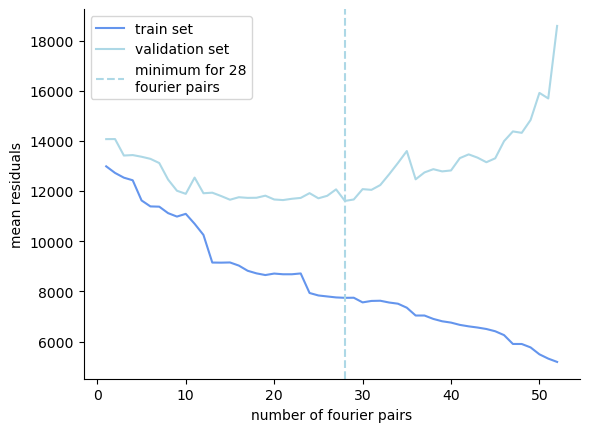

In [153]:
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(1,max_fourier+1), residuals_train_f[loc], color='cornflowerblue', label='train set')
plt.plot(range(1,max_fourier+1), residuals_test_f[loc], color='lightblue', label='validation set')
test_min_f = np.argmin(residuals_test_f[loc].values)+1
plt.axvline(test_min_f, color='lightblue', label='minimum for '+str(test_min_f)+'\nfourier pairs', linestyle='--')
plt.xlabel('number of fourier pairs')
plt.ylabel('mean residuals')
    
plt.legend()
plt.show()

In [144]:
fourier = CalendarFourier(freq="A", order=28)

In [145]:
##create training values
dp = DeterministicProcess(
    index=weeks_trainval.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

X_fore = dp.out_of_sample(steps=len(weeks_test))

In [149]:
X

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)",...,"sin(24,freq=A-DEC)","cos(24,freq=A-DEC)","sin(25,freq=A-DEC)","cos(25,freq=A-DEC)","sin(26,freq=A-DEC)","cos(26,freq=A-DEC)","sin(27,freq=A-DEC)","cos(27,freq=A-DEC)","sin(28,freq=A-DEC)","cos(28,freq=A-DEC)"
weekdate,,,,,,,,,,,,,,,,,,,,,
2018-01-07,1.0,1.0,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.401488,0.915864,...,0.615285,-0.788305,0.530730,-0.847541,0.440519,-0.897743,0.345612,-0.938377,0.247022,-0.969010
2018-01-14,1.0,2.0,0.221922,0.975065,0.432776,0.901502,0.622047,0.782980,0.780296,0.625411,...,-0.790946,0.611886,-0.635432,0.772157,-0.448229,0.893919,-0.238673,0.971100,-0.017213,0.999852
2018-01-21,1.0,3.0,0.337523,0.941317,0.635432,0.772157,0.858764,0.512371,0.981306,0.192452,...,0.917584,-0.397543,0.729558,-0.683919,0.455907,-0.890028,0.128748,-0.991677,-0.213521,-0.976938
2018-01-28,1.0,4.0,0.448229,0.893919,0.801361,0.598181,0.984474,0.175531,0.958718,-0.284359,...,-0.987349,0.158559,-0.811539,0.584298,-0.463550,0.886071,-0.017213,0.999852,0.432776,0.901502
2018-02-04,1.0,5.0,0.552435,0.833556,0.920971,0.389630,0.982927,-0.183998,0.717677,-0.696376,...,0.995919,0.090252,0.880012,-0.474951,0.471160,-0.882048,-0.094537,-0.995521,-0.628763,-0.777597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-28,1.0,204.0,-0.552435,0.833556,-0.920971,0.389630,-0.982927,-0.183998,-0.717677,-0.696376,...,-0.995919,0.090252,-0.880012,-0.474951,-0.471160,-0.882048,0.094537,-0.995521,0.628763,-0.777597
2021-12-05,1.0,205.0,-0.448229,0.893919,-0.801361,0.598181,-0.984474,0.175531,-0.958718,-0.284359,...,0.987349,0.158559,0.811539,0.584298,0.463550,0.886071,0.017213,0.999852,-0.432776,0.901502
2021-12-12,1.0,206.0,-0.337523,0.941317,-0.635432,0.772157,-0.858764,0.512371,-0.981306,0.192452,...,-0.917584,-0.397543,-0.729558,-0.683919,-0.455907,-0.890028,-0.128748,-0.991677,0.213521,-0.976938


2998.326683003399
6160.201699756911


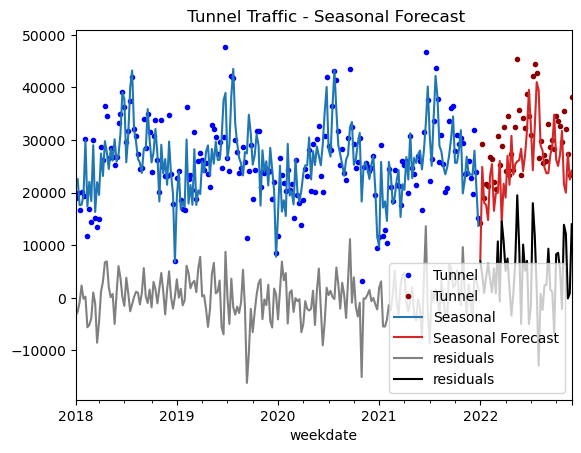

4983.818285227934
12089.376233220095


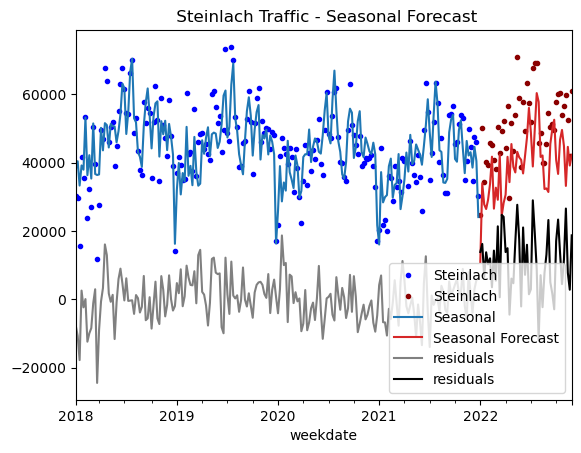

1140.6984914292696
2185.4917068143486


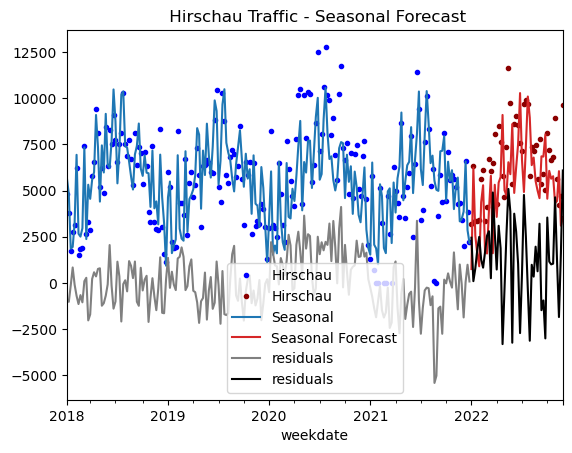

8225.951267584267
19556.009495383078


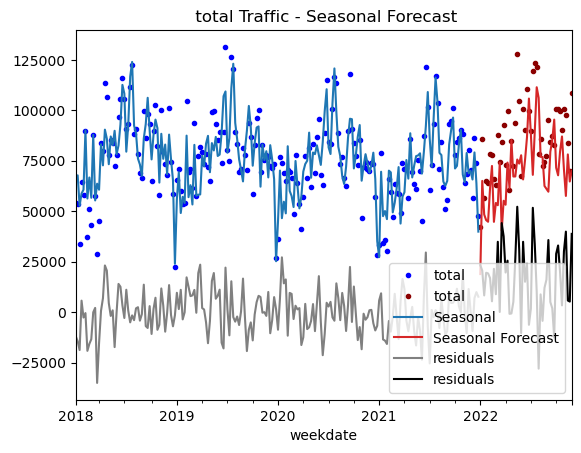

In [146]:
fig, a = plt.subplots(1,1)
y = weeks_trainval[loc]
y_test = weeks_test[loc]
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)
  
y_pred = model.predict(X)
y_fore = model.predict(X_fore)
    
train_residuals = y - y_pred
test_residuals = y_test -y_fore
train_residuals_abs = np.abs(train_residuals)
test_residuals_abs = np.abs(test_residuals)
print(sum(train_residuals_abs)/len(train_residuals_abs))
print(sum(test_residuals_abs)/len(test_residuals_abs))
  
y_pred = pd.Series(y_pred, index=y.index)
y_fore = pd.Series(y_fore, index=X_fore.index)
tit=f" {loc} Traffic - Seasonal Forecast"

a = y.plot(color="blue", style='.', title=tit)
a = y_test.plot(color="darkred", style='.')
a = y_pred.plot(ax=a, label="Seasonal")
a = y_fore.plot(ax=a, label="Seasonal Forecast", color='C3')
a = train_residuals.plot(ax=a, label='residuals', color='grey')
a = test_residuals.plot(ax=a, label='residuals', color='black')
_ = a.legend()

plt.show()